# Difference-in-Differences

Difference-in-differences (DiD) is a statistical technique used in econometrics to estimate the causal effect of a treatment on a time series {cite}`donald2007inference`. For example, it might be used to **evaluate the effect of a new policy** on the electricity prices, in a specific region. 

Let us suppose we collected some data from electricity prices over time, and we know that at a certain point in time a new policy was introduced. Let us also suppose that we observed a change in the trend, and we would like to attribute that change to the newly introduced policy. To be sure that the change in price time series is indeed due to the new policy, we would need to know the **counterfactual**. The counterfactual represents what would have happened to the prices had the new policy not been introduced. Then, by comparing the prices observed under the new policy with what the prices would have been without the policy, we would finally be able to say that the prices changed because of the policy. Without the counterfactual, we might not be able to accurately determine the true effect of the policy because of:
- Other influencing factors: in the real world, multiple factors can influence electricity prices simultaneously. These could include changes in fuel prices, demand fluctuations, economic conditions, and other regulatory changes. Without a counterfactual, it is difficult to isolate the impact of the specific policy from these other variables.
- Temporal trends: electricity prices may follow certain trends over time regardless of the policy intervention. For instance, prices might be declining due to improvements in technology or increasing due to rising demand. The counterfactual helps to control for these underlying trends, providing a clearer picture of what the prices would have looked like in the absence of the policy.

Unfortunately, in observational data, we cannot observe the counterfactual, since we only have access to what has happened under the new policy. DiD tries to tackle this problem by comparing the changes in the prices over time before a treatment group and a control group, where:
- The **treatment group** is, for example, the data collected from a region where the new policy was introduced.
- The **control group** might refer to another region, where the new policy was not introduced.

While doing so, DiD relies a crucial assumption known as the **parallel trends assumption**. This assumption asserts that the treatment and control groups would have followed the same trajectory over time in the absence of the treatment. Using the parallel trends assumption, we can use the change of the prices of the control group as a counterfactual for the treatment group in the absence of the treatment. n simple terms, DiD means that we are looking at:

\begin{align}
    \text{DiD} = &(\text{price in treatment group before policy} - \text{price in treatment group after policy}) \\
    & - (\text{price in control group before policy} - \text{price in control group after policy})
\end{align}

In other words, we are checking if there is a **difference between the two individual differences**. The first difference measures the change in prices for the treatment group before and after the policy, while the second difference measures the change in prices for the control group before and after the policy. By subtracting these two differences, we can isolate the effect of the policy from other factors that might influence electricity prices over time.

In practice, a common approach to DiD is to specify a linear regression model for the outcome of interest (in this case the price) as in:

\begin{equation}
    y = \beta_0 + \beta_1 \, \text{group} + \beta_2 \, \text{period} + \beta_3 \, (\text{group} \times \text{period}) + \varepsilon
\end{equation}

where:
- $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ are the regression coefficients.
- "group" is a dummy variable (0 or 1) that indicates whether the observation is from the control group (0) or the treatment group (1).
- "period" is a dummy variable (0 or 1) that indicates whether the observation is from the period before the policy implementation (0) or after (1).
- "$\text{group} \times \text{period}$" is an interaction term to count for the **DiD causal effect**. This variable captures the combined effect of being in the treatment group and being in the post-policy period.

The model can be estimated with traditional methods such as ordinary least squares (OLS). DiD can also be extended to nonlinear or semi-parametric settings.


## Example
To provide a practical example, we will now generate some data for electricity prices over time for two regions: one where the policy was implemented (treatment group) and one where it was not (control group). We will include a change in the prices of the treatment gorup by adding a **policy effect** that reduces the prices of 10 units after the policy has been introduced.

In [1]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Generate time series data
n_periods = 100
time = np.arange(n_periods)
policy_start = 50  # Time when the policy starts

# Generate prices for control group
control_prices = 0.5 * time + np.random.normal(scale=2, size=n_periods)

# Generate prices for treatment group with a policy effect
treatment_prices = 50 + 0.5 * time + np.random.normal(scale=2, size=n_periods)
treatment_prices[policy_start:] += -10  # Policy effect

# Create a DataFrame
data = pd.DataFrame({
    'time': np.tile(time, 2),
    'price': np.concatenate([control_prices, treatment_prices]),
    'group': np.repeat(['control', 'treatment'], n_periods),
    'period': np.concatenate([np.zeros(policy_start), np.ones(n_periods - policy_start), np.zeros(policy_start), np.ones(n_periods - policy_start)])
})

data

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,time,price,group,period
0,0,0.993428,control,0.0
1,1,0.223471,control,0.0
2,2,2.295377,control,0.0
3,3,4.546060,control,0.0
4,4,1.531693,control,0.0
...,...,...,...,...
195,95,88.270635,treatment,1.0
196,96,86.232285,treatment,1.0
197,97,88.807450,treatment,1.0
198,98,89.116417,treatment,1.0


Let's now plot the time series corresponding to the treatment and control groups to visually explore potential effects.

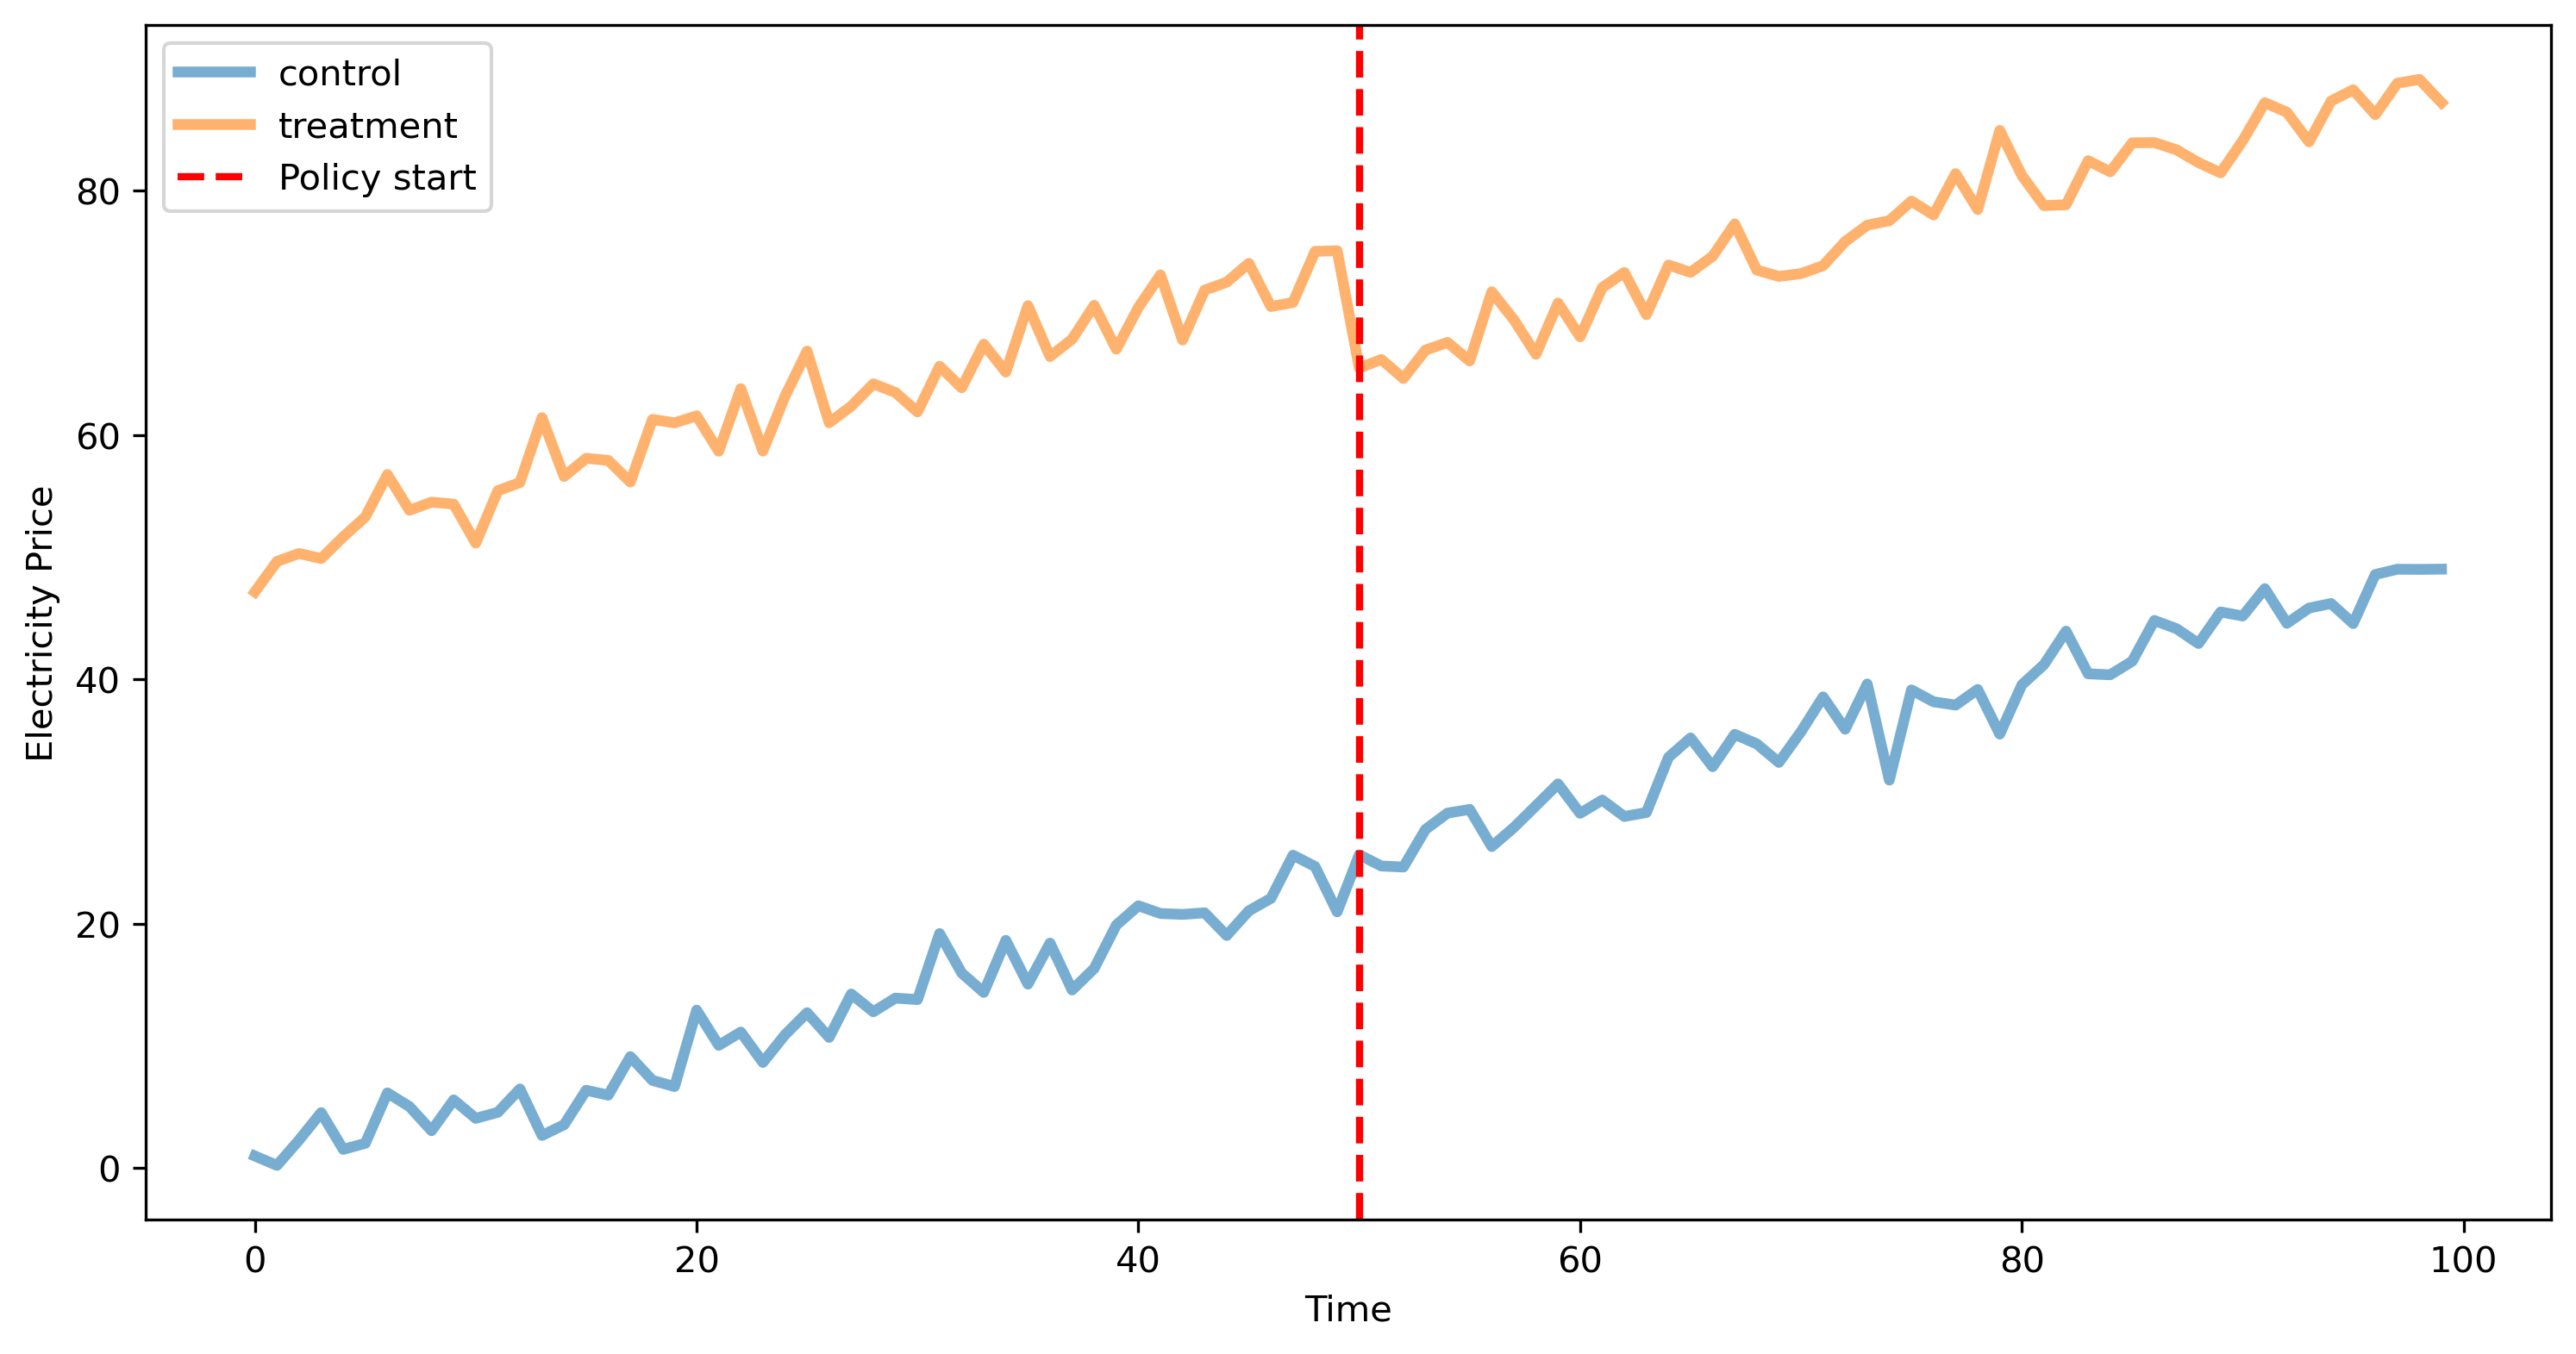

In [2]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(12, 6), dpi=300)
for key, grp in data.groupby('group'):
    plt.plot(grp['time'], grp['price'], label=key, lw=3, alpha=.6)
plt.axvline(policy_start, color='red', linestyle='--', label='Policy start', lw=2)
plt.xlabel('Time')
plt.ylabel('Electricity Price')
plt.legend()
plt.show()

As we can see, the prices in the treatment group appears to have slightly changed after the policy. Using the **parallel trends assumption**, we check for the difference in the prices, assuming the price in the treatment group would have followed the same trend of the control group.

Before fitting a DiD model, we need to create the dummy variables related to the group and the interaction between the group and the policy.

In [3]:
# Create a dummy variable for the group
data['group'] = np.where(data['group'] == 'treatment', 1, 0)

# Add an interaction term for DiD
data['interaction'] = data['group'] * data['period']

We now fit a simple OLS model on the data:

In [4]:
import statsmodels.api as sm

X = sm.add_constant(data[['group', 'period', 'interaction']])
y = data['price']
model = sm.OLS(y, X).fit()
print(model.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     778.6
Date:                Thu, 19 Dec 2024   Prob (F-statistic):          1.37e-108
Time:                        12:08:51   Log-Likelihood:                -679.31
No. Observations:                 200   AIC:                             1367.
Df Residuals:                     196   BIC:                             1380.
Df Model:                           3                                         
Covariance Type:            nonrobust  

We can see that the **interaction coefficients captures the causal effect of the policy**, accurately showing that the policy caused an increase of 10 units in the prices of the treatment group. This interaction term captures the differential effect of the policy on the treatment group relative to the control group, accounting for time trends common to both groups. A significant negative coefficient suggests that the policy led to a **reduction in prices for the treatment group compared to the control group**.

The **interaction term** effectively isolates the impact of the policy on the treatment group by controlling for:
- Any pre-existing differences between the treatment and control groups (coefficient "group").
- Any changes over time that would affect both groups equally (coefficient "period").